#### setting up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sys import path as syspath
syspath.append("functions/")

%load_ext autoreload
%autoreload 1
%aimport data_functions, model_functions
import os
from collections import OrderedDict
import pickle
# from data_functions import *
from model_functions import *
from copy import deepcopy
from Bio import SeqIO
bases = "acgt"
lett_to_index = dict(zip(bases,range(4)))
from scipy.special import logsumexp

In [2]:
def tally(x):
    return pd.Series(x).value_counts().sort_index()

In [3]:
genome = SeqIO.read("Ecoli/NC_000913.gbk", "genbank")

In [4]:
fttypes = set([ft.type for ft in genome.features])
genomeFlags = OrderedDict([])
take = OrderedDict([])
for fttype in fttypes:
    # print (fttype)
    take[fttype] = [ft for ft in genome.features if ft.type==fttype]
    nparts = [len(ft.location.parts) for ft in take[fttype]]
    # assert all parts within features are on the same strand
    for ft in take[fttype]:
        pts = ft.location.parts
        assert np.all([pt.strand==pts[0].strand for pt in pts])
    locs = [pt for ft in take[fttype] for pt in ft.location.parts]
    x = np.zeros((2,len(genome)))
    for il,lc in enumerate(locs):
        k = int(lc.strand<0)
        assert lc.start == lc.nofuzzy_start
        assert lc.end   == lc.nofuzzy_end
        x[k,lc.start:lc.end] = 1
    genomeFlags[fttype] = x


genFilter = OrderedDict([
    ################ intra-genic ################
    ("within", np.vstack([genomeFlags[k] for k in [
                        "misc_feature",
                        # "mobile_element",
                        # "repeat_region",
                        # "rep_origin",
                        # "tRNA",
                        # "STS",
                        # "tmRNA",
                        # "source"
                        # "rRNA",
                        # "ncRNA",
                        "CDS",
                        "gene",
                    ]]).sum(axis=0)>0),
    ################ inter-genic ################
    ("outside", np.vstack([genomeFlags[k] for k in [
                        "misc_feature",
                        "mobile_element",
                        "repeat_region",
                        # "rep_origin",
                        "tRNA",
                        "STS",
                        "tmRNA",
                        # "source"
                        "rRNA",
                        "CDS",
                        "gene",
                        "ncRNA",
                    ]]).sum(axis=0)==0),
    ])

In [5]:
numGen = np.array([lett_to_index[l] for l in genome.seq.lower()],dtype=np.int8)

In [6]:
baseFrac = {}
for fl in genFilter:
    a = np.array(tally(numGen[genFilter[fl]]))
    baseFrac[fl] = a/a.sum()

In [7]:
baseFrac

{'within': array([0.24113055, 0.25934596, 0.25857065, 0.24095284]),
 'outside': array([0.29509327, 0.20487764, 0.2063366 , 0.29369249])}

In [8]:
with open("models/fitted_on_Pr.Pl.36N/model_[5]_extended", "rb") as f:
    theModel = pickle.load(f)

In [9]:
# treat sequences as if they come from 36N library
# (essentially, only affects which chemical potential is used)
treatAs = "36N"

In [10]:
# we are not interested to model how rc binding interferes with frw.
# but are using the rc strand as an independent strand.
# so, we can turn off the rc flag in the model
theModel["includeRC"] = False

In [11]:
genOffset = sum(theModel["Layout"]) + theModel["spFlex"] # depends on the Layout and spFlex
numSeqs = np.array([
    np.hstack([numGen[-genOffset:],numGen      ]),
  3-np.hstack([numGen      ,numGen[: genOffset]])[::-1],
    
], dtype=np.int8)

assert np.all(numSeqs>=0)

In [12]:
bricks = getBrickDict({treatAs: numSeqs}, theModel)[treatAs]
freeEs = -logsumexp(-bricks, axis=-1)

In [13]:
FreeEnergy = { fl: freeEs[:,genFilter[fl]].flatten() for fl in genFilter }

In [23]:
# %%time  # 1h 10mins
# NrndGenome = int(1e8)

# rndFreeEs = OrderedDict()
# for fl in baseFrac:
#     np.random.seed(0)
#     rndGenome = np.random.choice(range(4), size=NrndGenome, p=baseFrac[fl])
#     rndSeq = np.array([
#             np.hstack([rndGenome[-genOffset:],rndGenome      ]),
#           3-np.hstack([rndGenome,rndGenome[: genOffset]])[::-1],
#         ], dtype=np.int8)
#     bricks = getBrickDict({treatAs: rndSeq}, theModel)[treatAs]
#     rndFreeEs[fl] = -logsumexp(-bricks, axis=-1).flatten()

In [36]:
{fl:rndFreeEs[fl].size/FreeEnergy[fl].size for fl in genFilter}

{'within': 24.04800559068034, 'outside': 223.76570835272636}

In [124]:
# with open("nbdumps/random_genome_free_energies.dmp","wb") as f:
#     pickle.dump(rndFreeEs,f)

In [24]:
with open("nbdumps/random_genome_free_energies.dmp","rb") as f:
    rndFreeEs = pickle.load(f)

In [25]:
db = .2
bbs = np.arange(freeEs.min()-1, freeEs.min()+20, db)
bbs -= db/2

In [26]:
binCenters = (bbs[:-1]+bbs[1:])/2

In [27]:
rndCdf = {fl: [(rndFreeEs[fl]<l).sum()/rndFreeEs[fl].size for l in bbs[1:]] for fl in genFilter}

In [28]:
realCumulHist = {fl: np.array([(FreeEnergy[fl]<l).sum() for l in bbs[1:]]) for fl in genFilter}

In [29]:
rndCumulHist = {fl: np.array(rndCdf[fl])*FreeEnergy[fl].size for fl in genFilter}

In [30]:
offset = freeEs.min()

In [31]:
x = binCenters-offset

In [32]:
from scipy.stats import distributions as dst

In [33]:
CI = .95

(0.3, 3849464.132914298)

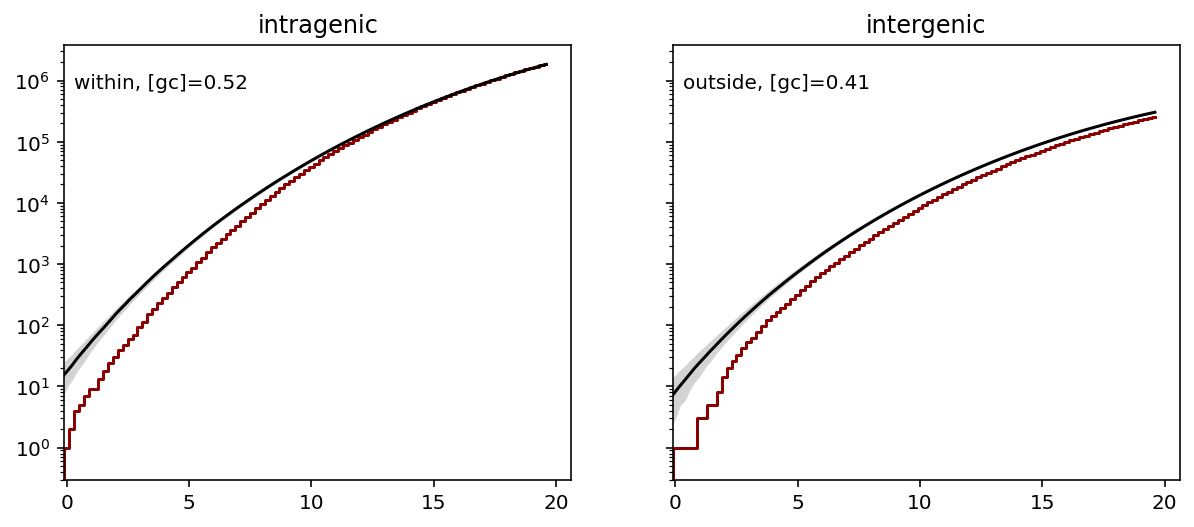

In [34]:
fig, axs = plt.subplots(1,2,figsize=(10,4), sharey=True)
for ax,fl in zip(axs, genFilter):
    ax.text(.02,.9, f"{fl}, [gc]={baseFrac[fl][1:3].sum():.2f}", transform=ax.transAxes)
    ax.set_title("intergenic" if fl=="outside" else "intragenic")
    ax.step(x, realCumulHist[fl], where="mid", color="darkred")
#     ax.step(x, rndCumulHist[fl], where="mid")
    ax.plot(x, rndCumulHist[fl], color="k")
#     ax.plot(x, )
    
    
    ax.fill_between(x,
                    dst.poisson.ppf(1-(1-CI)/2,mu=rndCumulHist[fl]),
                    dst.poisson.ppf((1-CI)/2,mu=rndCumulHist[fl]), 
                    color="lightgrey"
                   )
    ax.set_yscale("log")
    ax.set_xlim(-.1,)
plt.ylim(.3,)

In [ ]:
# full_dn panel with cumm p-value
NreBin = 1
Nsigma = 2
fig,axs = plt.subplots(2,2,figsize=(7,4.5), gridspec_kw={"height_ratios":[3,1.8]}, sharex=True, sharey="row")
fitID = 'full'#'full-CR-rc'
dinu = 1
x = freeEbinCenters[:len(freeEbinCenters)//NreBin*NreBin].reshape((-1,NreBin)).mean(1)
dx = x[1]-x[0]
ixmax = np.where(x>=freeE[fitID].min())[0][0]
xoffset = x[ixmax]
x = x-xoffset+dx/2
for axx,fl in zip([axs.T[0],axs.T[1]],["outside", "within"]):
    Yshow = pd.DataFrame({"x":x})
    for yht in ["YH", "YHreal"]:
        Yshow[("real" if "real" in yht else "rnd")] = eval(yht+"['"+fitID+"_"+fl+"_dn"*dinu+"']")
    for k in ["real","rnd"]:
        Yshow[k+"_p"] = np.cumsum(Yshow[k])/Yshow[k].sum()
        Yshow[k+"_p_err"] = (Yshow[k+"_p"]*(1-Yshow[k+"_p"])/Yshow[k].sum())**.5
    yexp = Yshow["rnd_p"]*Yshow["real"].sum()
    axx[0].set_title("intergenic" if fl=="outside" else "intragenic")
    axx[0].step(Yshow["x"],yexp.values,where="mid",c="k",
                    label=r"expected ($\pm %i\sigma$)"%Nsigma)
    axx[0].fill_between(
        np.array([Yshow["x"]-dx/2,Yshow["x"]+dx/2]).T.flatten(),
        np.array([yexp.values+Nsigma*yexp**.5]*2).T.flatten(),
        np.array([yexp.values-Nsigma*yexp**.5]*2).T.flatten(),
        alpha = .3,color="grey"
                       )
    axx[0].step(Yshow["x"],np.cumsum(Yshow["real"]),where="mid",c="darkred",label="observed")
    yexpErr = yexp**.5
    zscore = (np.cumsum(Yshow["real"])-yexp)/yexpErr
    log10pvs = np.maximum(dst.norm.logcdf(zscore)/np.log(10),-1000)
    axx[1].step(Yshow["x"],log10pvs,where="mid",color=c)
    for resc in [1]:
        tmp = Yshow.query("x>%f"%((measurableFreeE-xoffset)*resc)).iloc[0]
        twoNS = np.log(tmp["real_p"]/tmp["rnd_p"])
        twoNSerr = np.sqrt(tmp["real_p_err"]**2/tmp["real_p"]**2 + tmp["rnd_p_err"]**2/tmp["rnd_p"]**2)
        twoNSz = twoNS/twoNSerr
        pv = np.maximum(dst.norm.logcdf(twoNSz)/np.log(10),-100)
        print ("%20s \t %.5f %.5f %3.1e"%(fl, twoNS, twoNSerr,10**pv))
    print ('='*30)

for ax in axs.flat: ax.axvline(measurableFreeE-xoffset,color="grey",ls="--",lw=.7)
for ax in axs[0]:
    ax.set_yscale("log")
    ax.set_xlim(-.02,16)
    ax.set_ylim(.8,3e5)
for ax in axs[1]:
    ax.set_yscale("symlog")
    ax.set_ylim(-110,-.2)

axs[0,0].set_ylabel("number of bindings $\leq \Delta E$")
axs[0,0].legend(loc=4)
for ax in axs[1]:
    ax.set_xlabel("b.s. free energy $\Delta E$")
    ax.yaxis.set_minor_locator(MinorSymLogLocator(1))
    ax.grid(which="both",lw=.4,axis="y")
ax = plt.subplot(axs[1,0])
yt = list(plt.yticks()[0].astype(int))[:-1]
plt.yticks(yt,yt)
ax.set_ylabel(r"$\log _{10}$ p-value"+"\nfor "+r"$s<0$")
# ax.set_ylabel(r"$p$-value"+"\nfor "+r"$s<0$")
plt.subplots_adjust(hspace=0.01,wspace=0.1)
# fig.tight_layout()
# fig.savefig("figures/CDF_free_energy.pdf")
# fig.savefig("figures/CDF_free_energy.eps")